## Оценка качества соединения в облачном гейминге (Задача классификации)

Загрузка библиотек

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures , StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,Ridge,LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline,make_pipeline
from category_encoders import BaseNEncoder

from imblearn.over_sampling import SMOTE  

<span style='color:Blue ;
             font-size:20px;'>
    1) Обработка данных и визуализация.  </span><br>

Загрузка данных

In [3]:
Train_df = pd.read_csv('./train_data.csv')
Test_df = pd.read_csv('./test_data.csv')
Train_df.head(5)

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


Кодирование категориальных признаков

In [4]:
# Типы данных каждого признака:
print("Типы данных каждого признака:")
print(Train_df.dtypes)
print("\n")
cat_feats = Train_df.select_dtypes(include=['object']).columns.tolist()

# Вызов декоратора:
encoder = BaseNEncoder(cols=cat_feats, return_df=True, base=5)

# Применение декоратора к данным:
encoder.fit(Train_df)
encoded_data = encoder.transform(Train_df)
test_encoded_data = encoder.transform(Test_df)

# Вывод данных:
print("Закондированные данные:")
display(encoded_data.head(5))

Типы данных каждого признака:
fps_mean               float64
fps_std                float64
fps_lags                 int64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
auto_bitrate_state      object
auto_fec_state          object
auto_fec_mean          float64
stream_quality           int64
dtype: object


Закондированные данные:


,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state_0,auto_fec_state_0,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,1,1,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,1,1,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,1,1,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,1,1,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,1,1,50.0,0


Выбор целевой переменной:

In [32]:
X_train = encoded_data.drop(['stream_quality'],axis=1)
y_train = encoded_data['stream_quality']
X_test = test_encoded_data.drop(['stream_quality'],axis=1)
y_test = test_encoded_data['stream_quality']
target = 'stream_quality'

Масштабирование данных:

In [33]:
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Матрица корреляции:

In [34]:
corr = Train_df.corr()
corr.style.background_gradient()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_fec_mean,stream_quality
fps_mean,1.000000,0.178797,-0.342883,-0.027928,-0.042884,-0.104154,-0.044312,-0.107199,0.126417,-0.179298
fps_std,0.178797,1.000000,0.111428,0.164850,0.203251,-0.021631,-0.009202,-0.022263,0.037748,0.203023
fps_lags,-0.342883,0.111428,1.000000,0.050096,0.068576,0.313418,0.133342,0.322580,-0.111033,0.462141
rtt_mean,-0.027928,0.164850,0.050096,1.000000,0.764175,-0.014035,-0.005924,-0.014427,-0.008390,0.093005
rtt_std,-0.042884,0.203251,0.068576,0.764175,1.000000,-0.004323,-0.001718,-0.004424,-0.033902,0.106193
dropped_frames_mean,-0.104154,-0.021631,0.313418,-0.014035,-0.004323,1.000000,0.225323,0.974095,-0.050764,0.129474
dropped_frames_std,-0.044312,-0.009202,0.133342,-0.005924,-0.001718,0.225323,1.000000,0.411604,-0.021452,0.055084
dropped_frames_max,-0.107199,-0.022263,0.322580,-0.014427,-0.004424,0.974095,0.411604,1.000000,-0.052153,0.133259
auto_fec_mean,0.126417,0.037748,-0.111033,-0.008390,-0.033902,-0.050764,-0.021452,-0.052153,1.000000,-0.031317
stream_quality,-0.179298,0.203023,0.462141,0.093005,0.106193,0.129474,0.055084,0.133259,-0.031317,1.000000


<span style='color:Blue ;
             font-size:20px;'>
    2) Отбор признаков  </span><br>

Отбор признаков с использованием L1-регуляризации:

In [36]:
%matplotlib inline
alphas = [1e-6,5e-6,1e-5,1e-4,1e-3,0.01,0.1]
Feat_names = list(X_train.columns.values)

def lasso(alphas):
    """ Функция, возвращающая DataFrame с коэффициентами Лассо """
    df = pd.DataFrame()
    df['Feature Name'] = Feat_names
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        column_name = 'Alpha = %f' % alpha
        df[column_name] = lasso.coef_
    return df

L1_coef_df = lasso(alphas)
L1_coef_df.head(10)

,Feature Name,Alpha = 0.000001,Alpha = 0.000005,Alpha = 0.000010,Alpha = 0.000100,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.100000
0,fps_mean,-0.172086,-0.171660,-0.171128,-0.145253,-0.000000,-0.000000,-0.0
1,fps_std,3.315586,3.303387,3.288135,2.723712,0.000000,0.000000,0.0
2,fps_lags,0.986426,0.986354,0.986264,0.993346,0.985733,0.234188,0.0
3,rtt_mean,0.704487,0.800721,0.921212,0.303104,0.000000,0.000000,0.0
4,rtt_std,1.438669,0.974372,0.393592,0.000000,0.000000,0.000000,0.0
5,dropped_frames_mean,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0
6,dropped_frames_std,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0
7,dropped_frames_max,-0.041321,-0.034903,-0.026881,-0.000000,-0.000000,0.000000,0.0
8,auto_bitrate_state_0,0.027776,0.027928,0.028118,0.027025,0.007622,0.000000,0.0
9,auto_fec_state_0,-0.026550,-0.026251,-0.025878,-0.024034,-0.010920,0.000000,0.0


In [37]:
"""
Используя полученный DataFrame, мы можем выбрать наиболее подходящие коэффициенты alpha для выбора лучших признаков
"""
Alpha = 1e-4
Model_selection = Lasso(alpha=Alpha)
Model_selection.fit(X_train,y_train)
importance = np.abs(Model_selection.coef_)

Important_features = np.array(Feat_names)[importance > 0]
print(Important_features)

['fps_mean' 'fps_std' 'fps_lags' 'rtt_mean' 'auto_bitrate_state_0'
 'auto_fec_state_0' 'auto_fec_mean']


<span style='color:Blue ;
             font-size:20px;'>
    3) Задача классификации  </span><br>

In [40]:
def metrics_fun(method,X_train,X_test,y_train,y_test):
    """ Функция для рассчёта метрик """
    # Для тестовых данных
    y_pred_test = method.predict(X_test)
    Acc = metrics.accuracy_score(y_test, y_pred_test)
    Prec = metrics.precision_score(y_test, y_pred_test)
    Rec = metrics.recall_score(y_test, y_pred_test)
    Test_metrics = [Acc, Prec, Rec]
    
    # Для тренировочных данных
    y_pred_train = method.predict(X_train)
    Acc = metrics.accuracy_score(y_train, y_pred_train)
    Prec = metrics.precision_score(y_train, y_pred_train)
    Rec = metrics.recall_score(y_train, y_pred_train)
    Train_metrics = [Acc, Prec, Rec]
    
    # Преобразование в DataFrame
    d = {'Train_set' : Train_metrics , 'Test_set' : Test_metrics}
    Df = pd.DataFrame(data=d, index=["Accuracy", "Precision", "Recall_score"])
    return Df

#### Тренировка модели логистической регрессии для оценки качества соединения

In [41]:
clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train, y_train)  
y_pred = pipe.predict(X_test)
Metrics_Df = metrics_fun(pipe, X_train, X_test, y_train, y_test)
Metrics_Df.head(5)

,Train_set,Test_set
Accuracy,0.944672,0.940508
Precision,0.838640,0.707671
Recall_score,0.237515,0.130496


Матрица ошибок:

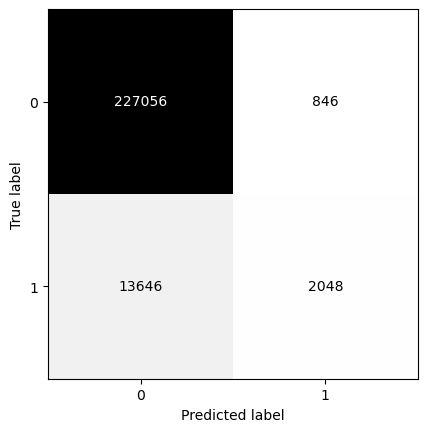

In [53]:
y_test = np.asarray(y_test).astype(int)
y_pred = np.asarray(y_pred).astype(int)
cm = metrics.confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(\
                                      confusion_matrix=cm,
                                      display_labels=clf.classes_,
                                     )
disp.plot(cmap = 'binary', colorbar = False)
plt.show()

<span style='color:Blue ;
             font-size:20px;'>
    4) Работа с выбросами. Метод Z-score.  </span><br>

In [57]:
def remove_outliers(train_df):
    non_cat_feats = train_df.select_dtypes(exclude=['object']).columns.tolist()
    non_cat_feats.remove('stream_quality')
    new_df = train_df.copy()
    for col in non_cat_feats:

        upper = new_df[col].mean() + 3 * new_df[col].std()
        lower = new_df[col].mean() -3 * new_df[col].std()
        
        new_df= new_df[(new_df[col]<upper) & (new_df[col]>lower)]
    
    return new_df
# Выбор данных в пределах критерия 3*sigma:
Train_df_Z = remove_outliers(Train_df)
# Кодирование:
encoded_data_Z = encoder.transform(Train_df_Z)
# Выбор целевой переменной:
X_train_Z = encoded_data_Z.drop(['stream_quality'],axis=1)
y_train_Z = encoded_data_Z['stream_quality']
# Масштабирование:
X_train_Z = pd.DataFrame(scaler.transform(X_train_Z), columns=X_train_Z.columns)

Исполнение модели:

In [59]:
clf_Z = pipe
clf_Z.fit(X_train_Z, y_train_Z)
y_pred_Z = clf_Z.predict(X_test)
Metrics_Df_Z = metrics_fun(clf_Z,X_train_Z,X_test,y_train_Z,y_test)
Metrics_Df_Z.head(5)

,Train_set,Test_set
Accuracy,0.963036,0.907942
Precision,0.558442,0.341437
Recall_score,0.016382,0.461769


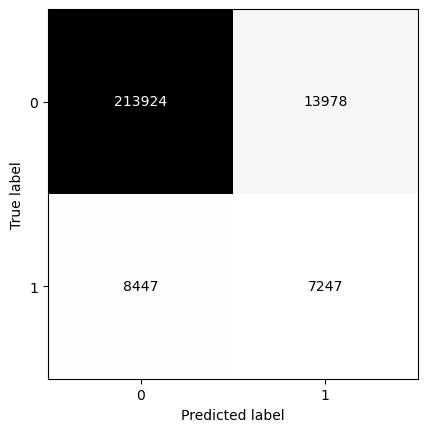

In [62]:
y_test = np.asarray(y_test).astype(int)
y_pred_Z = np.asarray(y_pred_Z).astype(int)
cm = metrics.confusion_matrix(y_test, y_pred_Z, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(\
                                      confusion_matrix=cm,
                                      display_labels=clf.classes_,
                                     )
disp.plot(cmap = 'binary', colorbar = False)
plt.show()

<span style='color:Blue ;
             font-size:20px;'>
    5) Работа с имбалансом. Алгоритм SMOTE  </span><br>

Распределение значений в тренировочном наборе:

In [64]:
print("Значения (1) целевой переменной: {}".format(sum(y_train == 1)))  
print("Значения (0) целевой переменной: {} \n".format(sum(y_train == 0)))  
sm1 = SMOTE(random_state = 2)  
X_train_smote, y_train_smote = sm1.fit_resample(X_train, y_train)
print("Значения (1) целевой переменной после SMOTE: {}".format(sum(y_train_smote == 1)))  
print("Значения (0) целевой переменной после SMOTE: {}".format(sum(y_train_smote == 0)))  

Значения (1) целевой переменной: 27834
Значения (0) целевой переменной: 378738 

Значения (1) целевой переменной после SMOTE: 378738
Значения (0) целевой переменной после SMOTE: 378738


Исполнение модели:

In [67]:
pipe_smote = make_pipeline(StandardScaler(), clf)
pipe_smote.fit(X_train, y_train)  
y_pred_smote = pipe_smote.predict(X_test)
Metrics_Df_smote = metrics_fun(pipe_smote,X_train_smote,X_test,y_train_smote,y_test)
Metrics_Df_smote.head(5)

,Train_set,Test_set
Accuracy,0.616252,0.940516
Precision,0.985971,0.708017
Recall_score,0.235860,0.130559


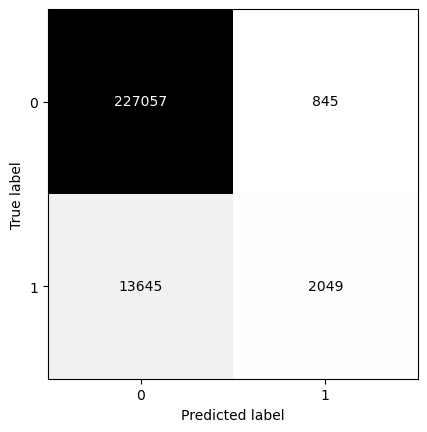

In [68]:
y_test = np.asarray(y_test).astype(int)
y_pred_smote = np.asarray(y_pred_smote).astype(int)
cm = metrics.confusion_matrix(y_test, y_pred_smote, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(\
                                      confusion_matrix=cm,
                                      display_labels=clf.classes_,
                                     )
disp.plot(cmap = 'binary', colorbar = False)
plt.show()